<a href="https://colab.research.google.com/github/morgwork/Distantly-Reading-IPCC-Reports/blob/main/IPCC_Topic_Modeling_%5Bincomplete%5D(4_17).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tomotopy
!pip install little_mallet_wrapper

In [ ]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob # directories
from pathlib import Path

In [ ]:
! unzip txts.zip

Archive:  txts.zip
replace IPCC1M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: nn
replace IPCC6M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IPCC5M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IPCC3M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IPCC2M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IPCC4M.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
directory = "/content/IPCCMTXT"

In [ ]:
files= glob.glob(f"{directory}/*.txt")
files

[]

In [ ]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)

len(training_data), len(original_texts), len(titles)

(0, 0, 0)

In [ ]:
# Number of topics to return
num_topics = 15
# Numer of words to print out in each cluster
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")
# Iterate over the data 200 times
iterations = 200
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Print out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: 0.0

Topic Model Results:


✨Topic 0✨



✨Topic 1✨



✨Topic 2✨



✨Topic 3✨



✨Topic 4✨



✨Topic 5✨



✨Topic 6✨



✨Topic 7✨



✨Topic 8✨



✨Topic 9✨



✨Topic 10✨



✨Topic 11✨



✨Topic 12✨



✨Topic 13✨



✨Topic 14✨





In [ ]:
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [ ]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

In [ ]:
get_top_docs(titles, topic_distributions, topic_index=5, n=6)


### ✨Topic 5✨

mitigation ghg energy emissions technology policies environmental non scenarios development

---

✨  
**Topic Probability**: 0.20032107830047607  
**Document**: IPCC4M



✨  
**Topic Probability**: 0.16800765693187714  
**Document**: IPCC3M



✨  
**Topic Probability**: 0.002325671259313822  
**Document**: IPCC2M



✨  
**Topic Probability**: 0.0008743650396354496  
**Document**: IPCC6M



✨  
**Topic Probability**: 3.6544374779623467e-06  
**Document**: IPCC1M



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

In [ ]:
target_labels = []

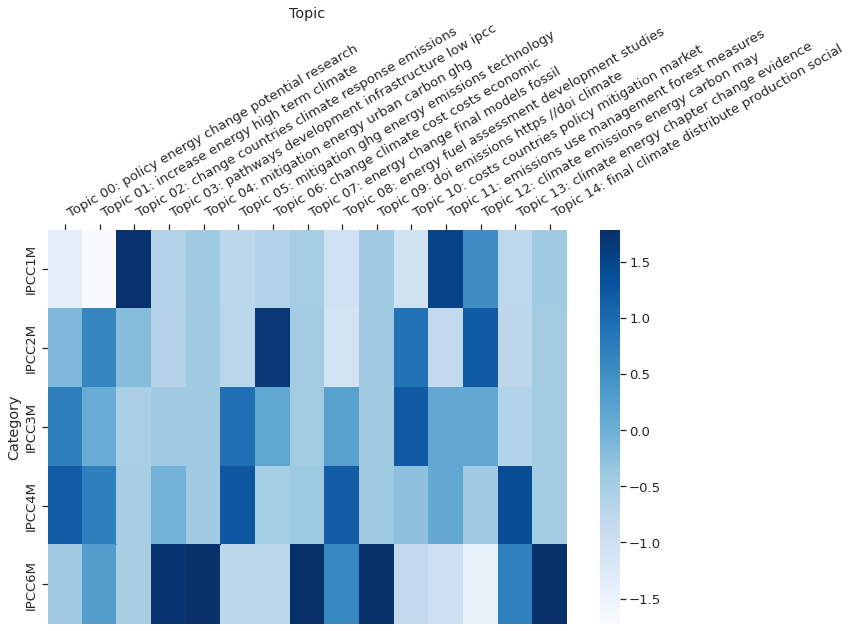

In [ ]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(12,9))

In [ ]:
# For all possible color maps, see https://matplotlib.org/stable/tutorials/colors/colormaps.html#miscellaneous

In [ ]:
import pandas as pd

topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)
column_names = [f"Topic {number} {' '.join(topic[:4])}" for number, topic in enumerate(topic_individual_words)]
df[column_names] = pd.DataFrame(df['topic_distribution'].tolist(), index = df.index)
df = df.drop('topic_distribution', axis='columns')

In [ ]:
df.to_csv('Topic-Distributions.csv', encoding='utf-8', index=False)